In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [23]:

path = 'drive/MyDrive/lfw/lfw/'

In [45]:

transform    = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
"""transform    = transforms.Compose([transforms.ToTensor()])"""
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [25]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


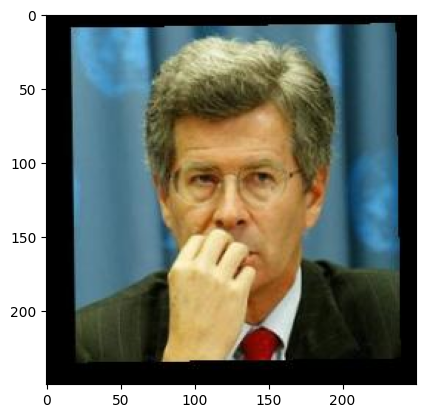

In [41]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [46]:

datapoint, _ = next(iter(dataloader))

print(f"Datapoint size: {datapoint.size()}")

print(
    "Explanation:\n"
    "\t- Dimension 0 (size 1): This represents a single sample (image) or Batch Size.\n"
    "\t- Dimension 1 (size 3): This represents the number of channels (R, G, B).\n"
    "\t- Dimension 2 (size H): This represents the height of the image.\n"
    "\t- Dimension 3 (size W): This represents the width of the image.\n"
)


Datapoint size: torch.Size([32, 3, 64, 64])
Explanation:
	- Dimension 0 (size 1): This represents a single sample (image) or Batch Size.
	- Dimension 1 (size 3): This represents the number of channels (R, G, B).
	- Dimension 2 (size H): This represents the height of the image.
	- Dimension 3 (size W): This represents the width of the image.



# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [28]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Assuming you want the output in the range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



This code defines a basic autoencoder in PyTorch. The encoder compresses input images through two convolutional layers with ReLU activation and batch normalization.
 The decoder reconstructs the original images using transposed convolutional layers with ReLU and batch normalization.
 The network aims to minimize the difference between input and reconstructed output during training.

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [29]:
model =AE()
img_tensor = torch.rand((1, 3, 256, 256))
output = model(img_tensor)
encoder_output = model.encoder(img_tensor)
decoder_output = model.decoder(encoder_output)

print("Encoder output shape:", encoder_output.shape)
print("Decoder output shape:", decoder_output.shape)


Encoder output shape: torch.Size([1, 32, 64, 64])
Decoder output shape: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters in the Model: {total_params}")


Total Number of Parameters in the Model: 10275


In [31]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
def loss_function(output, target):
    # Resize target tensor to match the output size
    target_resized = F.interpolate(target, size=(64, 64), mode='bilinear')
    # Calculate MSE loss
    loss = nn.MSELoss()(output, target_resized)
    return loss




1. **Adam Optimizer:** Efficiently handles sparse gradients common in images and is robust to noise.
2. **MSE Loss Function:** Simple and directly measures pixel-level reconstruction error, making it easy to interpret and computationally efficient.


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [33]:
num_epochs = 25 # You can adjust this based on your requirements
import torch.nn.functional as F

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    # Iterate over the batches in the data loader
    for x, _ in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x)

        # Calculate the loss
        loss = loss_function(output, x)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the total loss for this epoch
        total_loss += loss.item()

    # Calculate and print the average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

# Training complete
print('Training finished.')


Epoch [1/25], Loss: 0.409866344957536
Epoch [2/25], Loss: 0.31165719798941544
Epoch [3/25], Loss: 0.3048628218436011
Epoch [4/25], Loss: 0.3027623071906647
Epoch [5/25], Loss: 0.3008404061342207
Epoch [6/25], Loss: 0.300470617118377
Epoch [7/25], Loss: 0.2996917883123177
Epoch [8/25], Loss: 0.2992802560689369
Epoch [9/25], Loss: 0.2989685841012692
Epoch [10/25], Loss: 0.29870570001106905
Epoch [11/25], Loss: 0.29842980353584614
Epoch [12/25], Loss: 0.29797733247568065
Epoch [13/25], Loss: 0.29786320246648096
Epoch [14/25], Loss: 0.29767168057713533
Epoch [15/25], Loss: 0.2976256886470145
Epoch [16/25], Loss: 0.29749906163860634
Epoch [17/25], Loss: 0.29745865987550807
Epoch [18/25], Loss: 0.2973274425535962
Epoch [19/25], Loss: 0.2973281972578182
Epoch [20/25], Loss: 0.29729376150214154
Epoch [21/25], Loss: 0.29712834608727606
Epoch [22/25], Loss: 0.29707858261566805
Epoch [23/25], Loss: 0.2971609493600573
Epoch [24/25], Loss: 0.2970850703796903
Epoch [25/25], Loss: 0.2970780926770058


##  Troubling :

1. **Stagnant Loss:** Model stuck, not learning. Fix: data, hyperparameters, architecture.
2. **Overfitting:** Model remembers instead of learning. Fix: Augmentation, regularization, early stopping.
3. **Vanishing/Exploding Gradients:** Gradients go haywire, learning unstable. Fix: Activation functions, network depth, gradient clipping.
4. **Bad Data Preprocessing:** Noise and artifacts, model learns wrong features. Fix: Normalize, standardize, clean data.
5. **Wrong Loss Function:** Wrong tool for the job. Fix: Use SSIM or PSNR for better quality.


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

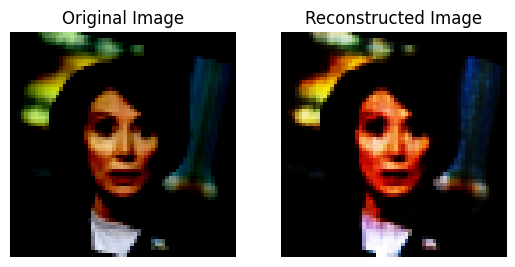

In [34]:
import random

# Get a random image from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)
sample_image, _ = dataloader.dataset[random_index]

# Plot the original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis('off')

# Encode and decode the image
with torch.no_grad():
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension
    reconstructed_image = model(sample_image)

# Plot the reconstructed image
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

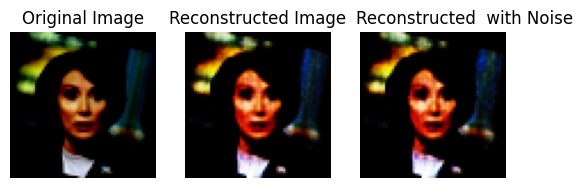

In [38]:
import random
import torch


sample_image, _ = dataloader.dataset[random_index]

# Plot the original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis('off')

# Encode the image
with torch.no_grad():
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension
    encoded_image = model.encoder(sample_image)

# Add small normally distributed noise to the latent representation
noise = torch.randn_like(encoded_image) * 0.1  # Adjust the noise level as needed
noisy_encoded_image = encoded_image + noise

# Decode the noisy representation
with torch.no_grad():
    reconstructed_noisy_image = model.decoder(noisy_encoded_image)

# Plot the reconstructed image
plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.squeeze().permute(1, 2, 0))
plt.axis('off')

# Plot the reconstructed image with noise
plt.subplot(1, 3, 3)
plt.title("            Reconstructed  with Noise")
plt.imshow(reconstructed_noisy_image.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.show()


Adding noise to autoencoders can encourage diverse and smoother reconstructions, but excessive noise leads to blurry and bright images. Reducing the noise level or using different types of noise can address this issue. Fine-tuning the model with noisy data further improves its ability to handle noise and achieve a desirable balance between diversity, fidelity, and image quality.